# Customer Segmentation Challenge Analysis

<p>Author: Dhouha Grissa</p>
Date: 18/03/2022


This notebook contains the different steps for analyzing a case study related to customer segmentation challenge data.

## 1) Load Libraries

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [141]:
#I have coded some functions that I need to call via the following file
%run functions_for_analysis.py

<Figure size 432x288 with 0 Axes>

In [140]:
%matplotlib inline
sns.set(context='poster', style='ticks')
pd.set_option('display.max_rows', 500)
fig = plt.figure(figsize=(8,11))

<Figure size 576x792 with 0 Axes>

## 2) Load data

<p>The data provided in the file "DS_customer_data_sample.csv" includes 10 features/variables to respond to the following binary classification problem: <b> What are the most important factors for predicting whether a customer has converted or not? </b>
    

In [4]:
# Set directory locations
ROADMAP_DIR = "/Users/dgrissa/Desktop/interviews/lenus_case_study/"
ROADMAP_DATA_DIR = ROADMAP_DIR + "data/"

In [5]:
#importing the dataset
customer_seg_data = pd.read_csv(ROADMAP_DATA_DIR + "DS_customer_data_sample.csv", sep=',')
print("The dimension of the data is: ", customer_seg_data.shape)
print("Overview of the input data: \n")
customer_seg_data.head(4)

The dimension of the data is:  (891, 10)
Overview of the input data: 



,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki


## 3) Exploratory Data Analysis 
<p> In this part, I will explore the data by assessing the quality of the data in terms of data distribution, missing values, feature types/distribution, correlation, etc. </p>

In [6]:
#extract the dependent/target variable
X_data = customer_seg_data.iloc[:, 0:]
X_data.drop("converted", axis=1,inplace=True)
y_data = customer_seg_data.iloc[:, 1]

## 3.1) Adjustment of variable types 

In [7]:
# Converting categorical variable 'Gender' to numeric
X_data['gender'].replace({'male':1, 'female':2}, inplace=True)

#Converting the categorical variable Branch into numeric
X_data['branch'].replace({'Helsinki':1, 'Tampere':2, 'Turku':3}, inplace=True)

#converting the variable 'account_id' into a Binary variable: we are interested in whether a customer has or not an account_id
#I put '0' if the customer doesn't have an account_id, otherwise I put '1'
for row in range(0, len(X_data)):
    if X_data.loc[row, "credit_account_id"] == "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0":
        X_data.loc[row, "credit_account_id"] = 0
    else:
        X_data.loc[row, "credit_account_id"] = 1
        
X_data.head(2)

,customer_id,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,13,1,22.0,1,0,14.5000,0,1.0
1,15002,11,2,38.0,1,0,142.5666,1,2.0


### 3.2)  Data distribution
<p> 
    </p>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-25.0, 100.0)

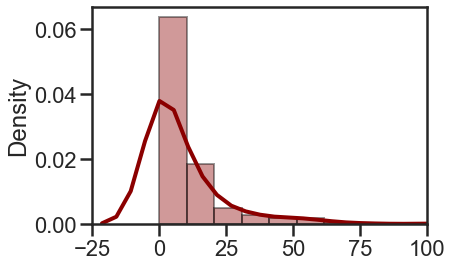

In [8]:
bp=sns.distplot(np.asarray(X_data.iloc[:,1:], float), hist=True, kde=True, bins=100,
             color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
bp.set_xlim(-25, 100)

### 3.3) Detection and Treatment of missing values
<p> I choose <b>Knn method for imputing missing data</b> like age, as a multivariate approach that takes other features into account, instead of using a univariate approach as mean or median that takes a single feature into account. 
    </p>

In [9]:
#--Count total number of  missing values
print(" \nCount total number of missing values NaN in customer_seg_data : ",
       X_data.isnull().sum().sum())
print(" \nCount the number of missing values per variable : \n",
       X_data.isnull().sum())

 
Count total number of missing values NaN in customer_seg_data :  179
 
Count the number of missing values per variable : 
 customer_id            0
customer_segment       0
gender                 0
age                  177
related_customers      0
family_size            0
initial_fee_level      0
credit_account_id      0
branch                 2
dtype: int64


>1 0.798 (0.039)
>3 0.799 (0.041)
>5 0.802 (0.040)
>7 0.801 (0.041)
>9 0.800 (0.041)
>15 0.803 (0.041)
>18 0.804 (0.042)
>21 0.802 (0.041)


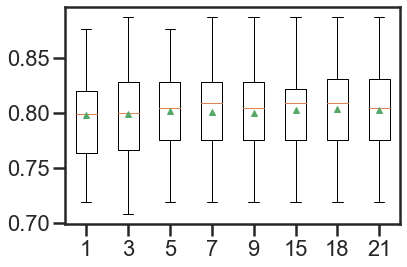

In [13]:
#Before applying knn, I need to choose the number of neighbours 'k' to use as an input parameter for knn 
choose_k_for_knn_imputation(X_data.iloc[:,1:], y_data)

In [34]:
#imputation of missing values without the 'branch' variable
imputed_X_data= imputation_with_knn(X_data.iloc[:,1:8], 18)

#I use 'most frequent' term to impute the 'branch' variable
imp = SimpleImputer(strategy='most_frequent')
imp.fit(np.array(X_data.iloc[:,8]).reshape(-1,1))
imputed_X_data["branch"] = imp.transform(np.array(X_data.iloc[:,8]).reshape(-1,1))
print("customer_seg_imputed data: \n")
imputed_X_data.iloc[53:57,:]

Missing values in the imputed dataset: 0
customer_seg_imputed data: 



,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
53,12.0,2.0,29.0,1.0,0.0,52.0000,0.0,1.0
54,11.0,1.0,65.0,0.0,1.0,123.9584,1.0,2.0
55,11.0,1.0,33.5,0.0,0.0,71.0000,1.0,1.0
56,12.0,2.0,21.0,0.0,0.0,21.0000,0.0,1.0


### 3.4) Identification of Atypical Data
<p> This section consists in the identification of atypical data among the features and samples, as Outliers. Fot that, I rely on the visualization of features boxplots, boxenplot, distribution curves, and histograms. I also use swarmplots to see the distribution and relationships between different features. </p>

****Boxenplots of the input variables****


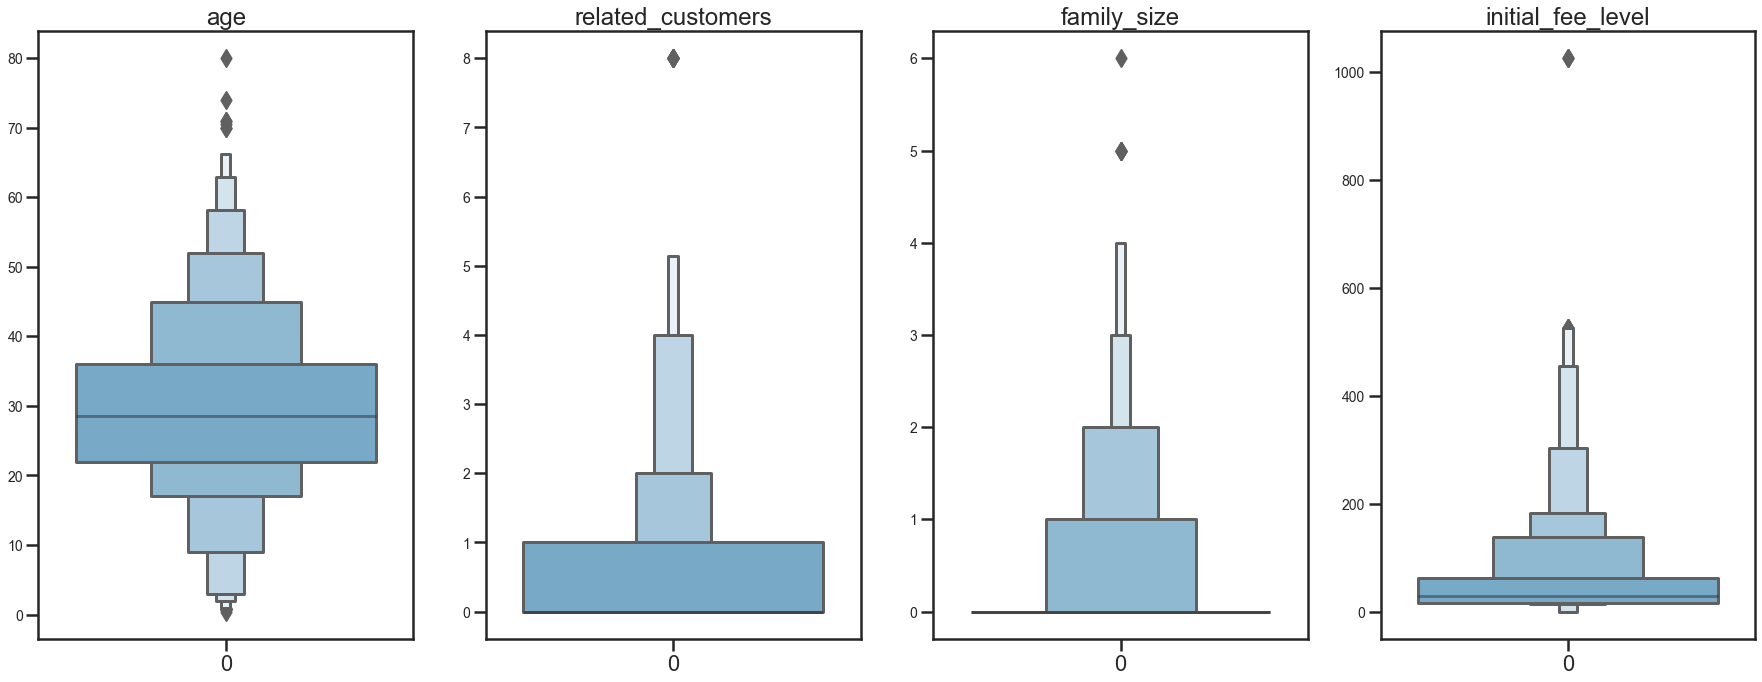

In [35]:
# I used boxenplots to identify outliers among the following features : 'age', 'related_customers', 'family_size', 'initial_fee_level'
feature_boxplot = ['age', 'related_customers', 'family_size', 'initial_fee_level']
print("****Boxenplots of the input variables****")
fig, axs = plt.subplots(1, len(feature_boxplot), figsize=(25,10))

for i, ax in enumerate(axs.flat):
        if (feature_boxplot[i] in imputed_X_data.columns) :
            feature_name = feature_boxplot[i]
            sns.boxenplot(data=imputed_X_data.loc[:, feature_name], orient='v', ax=axs[i], palette="Blues")
            ax.set_title(feature_boxplot[i])
            ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()

==> We consider as outilers all the 'black dots' plotted in the boxenplots.

#### --> Variable : "Age" 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

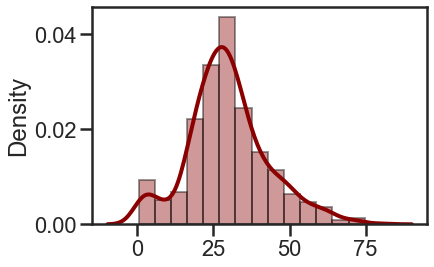

In [36]:
#Check the distribution of age using density plot to double check outliers
sns.distplot(np.asarray(imputed_X_data["age"], float), hist=True, kde=True, bins=15,
             color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#### --> Variable : "Initial_fee_level" 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

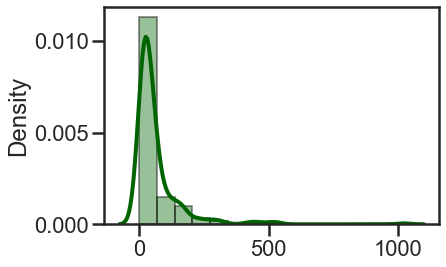

In [37]:
sns.distplot(np.asarray(imputed_X_data["initial_fee_level"], float), hist=True, kde=True, bins=15,
             color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### 3.5) Check the distribution of the remaining Categorical variables

#### --> Variable : "branch"

Text(0, 0.5, 'number')

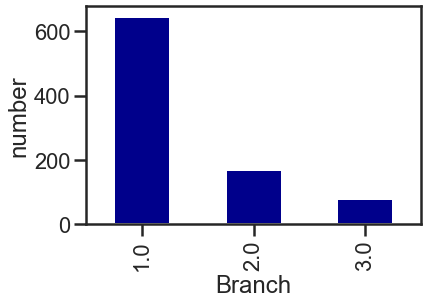

In [41]:
value=imputed_X_data["branch"].value_counts().plot(kind='bar', color= "darkblue")
plt.xlabel('Branch')
plt.ylabel('number')

#### --> Variable : "customer_segment"

Text(0, 0.5, 'number')

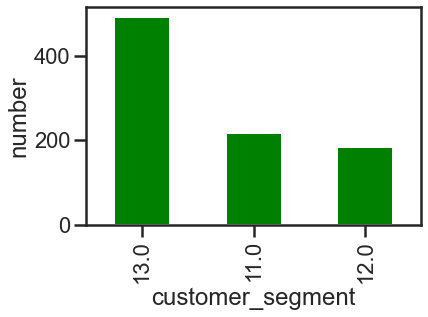

In [42]:
value=imputed_X_data["customer_segment"].value_counts().plot(kind='bar', color="green")
plt.xlabel('customer_segment')
plt.ylabel('number')

#### --> Variable : "gender"

Text(0, 0.5, 'nb. customers')

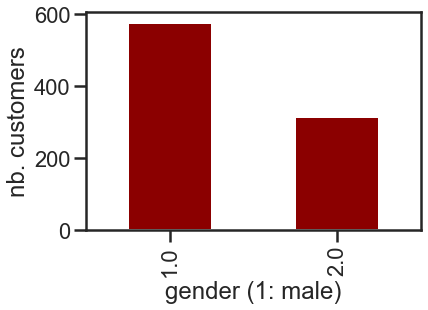

In [43]:
value=imputed_X_data["gender"].value_counts().plot(kind='bar', color="darkred")
plt.xlabel('gender (1: male)')
plt.ylabel('nb. customers')

#### --> Variable : "credit_account_id"

Text(0, 0.5, 'nb. customers')

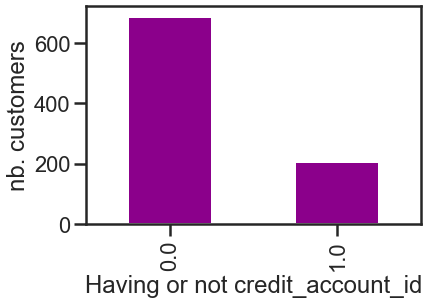

In [44]:
value=imputed_X_data["credit_account_id"].value_counts().plot(kind='bar', color= "darkmagenta")
plt.xlabel('Having or not credit_account_id')
plt.ylabel('nb. customers')

<p> According to the previous plots (boxplots, histograms, density cruves), we need to remove outliers from the following variables: age, related_customers, initial_fee_level and family_size. </br>
I have also noticed from the bar plots given above that a big number of the customers are male, affiliated to the branch 1 (Helsinki), belong to the customer segment 13, and do not have a cradit account id.
    </p>

### 3.6) Check the relationship between the variables
<p> To check the relationship between the variables, I compute the Pearson correlation to identify how close two variables are to having a linear relationship with each other. I also use violinplot and swarmplots to see how the variables are related to each others. </p>

#### --> Correlation
<p> From the plots given below, we distinguish that the highest correlation value is equal to 0.48 between these pairs of features (credit_account_id, initial_fee_level) and (related_customer, family_size). </br> 
All other features have low or moderate correlation among them.
</p>

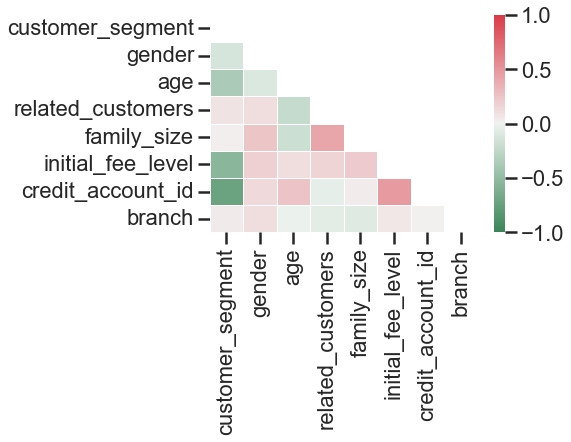

In [45]:
# compute the correlation
corre = imputed_X_data.corr()
# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)
# remove the top right triange - duplicate information
mask = np.zeros_like(corre, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
# construction of the heatmap
ans=sns.heatmap(corre, mask=mask,  linewidths=1, cmap=cmap,center=0, vmin=-1, vmax=1)

#### --> Visualize the relationship between the variables

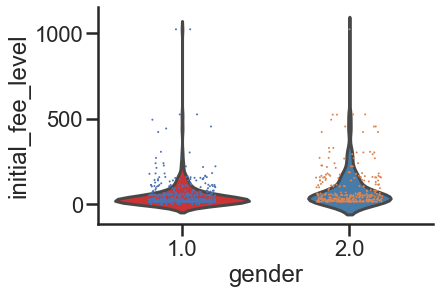

In [46]:
gender = imputed_X_data["gender"]
fee = imputed_X_data["initial_fee_level"]
ax = sns.violinplot(x= gender, y=fee, inner=None, palette="Set1",alpha=0.5)
ax = sns.stripplot(x= gender, y=fee, jitter=0.2, s=2)
sns.despine()
plt.xlabel("gender")
plt.ylabel("initial_fee_level")
plt.show()

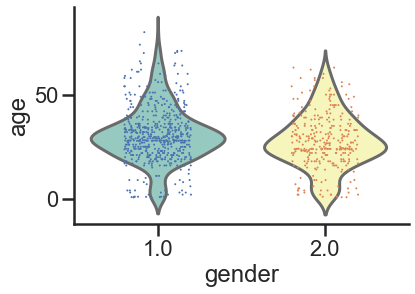

In [47]:
gender = imputed_X_data["gender"]
age = imputed_X_data["age"]
ax = sns.violinplot(x= gender, y=age, inner=None, palette="Set3",alpha=0.5)
ax = sns.stripplot(x= gender, y=age, jitter=0.2, s=2)
sns.despine()
plt.xlabel("gender")
plt.ylabel("age")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


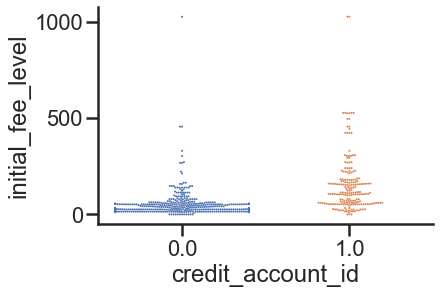

In [51]:
account = imputed_X_data["credit_account_id"]
fee = imputed_X_data["initial_fee_level"]
ax = sns.swarmplot(x= account, y=fee,dodge=True, s=2)
sns.despine()
plt.xlabel("credit_account_id")
plt.ylabel("initial_fee_level")
plt.show()

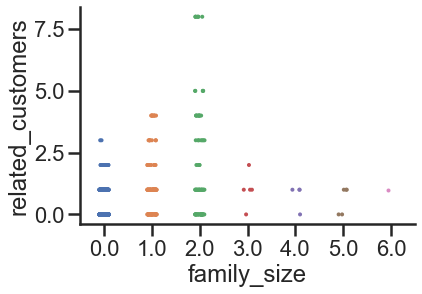

In [56]:
family = imputed_X_data["family_size"]
related = imputed_X_data["related_customers"]
ax = sns.stripplot(x= family, y=related,dodge=True, s=4)
sns.despine()
plt.xlabel("family_size")
plt.ylabel("related_customers")
plt.show()

The gender do not affect the other features. Most of the customer whho do not hhave a credit account id have -low- intial fee level 

#### --> Removal of outliers based on the previous results

In [57]:
#filtering of the outliers
df_X_all_imp_y = pd.concat([customer_seg_data[["converted", "customer_id"]], imputed_X_data], axis=1)
df_X_all_imp_filtered = pd.DataFrame(columns=df_X_all_imp_y.columns)
list_cust_id = set()
j=0
for row in range(0, len(df_X_all_imp_y)):
    if (df_X_all_imp_y.loc[row,"related_customers"] >=8) or (df_X_all_imp_y.loc[row,"age"] >=65) or (df_X_all_imp_y.loc[row,"age"] <=1) or (df_X_all_imp_y.loc[row,"initial_fee_level"] >1000) or (df_X_all_imp_y.loc[row,"family_size"] >=5):
        continue
    elif (df_X_all_imp_y.loc[row,"customer_id"] not in list_cust_id):
        df_X_all_imp_filtered.loc[j,:]=df_X_all_imp_y.loc[row,:]
        list_cust_id.add(df_X_all_imp_y.loc[row,"customer_id"])
        j+=1
print("The size of the dataset before removal of outliers is : ", df_X_all_imp_y.shape)
print("The size of the dataset after removal of outliers is: ", df_X_all_imp_filtered.shape)
print("\n")
print(df_X_all_imp_filtered.head(5))

The size of the dataset before removal of outliers is :  (891, 10)
The size of the dataset after removal of outliers is:  (850, 10)


  converted customer_id customer_segment gender   age related_customers  \
0       0.0     15001.0             13.0    1.0  22.0               1.0   
1       1.0     15002.0             11.0    2.0  38.0               1.0   
2       1.0     15003.0             13.0    2.0  26.0               0.0   
3       1.0     15004.0             11.0    2.0  35.0               1.0   
4       0.0     15005.0             13.0    1.0  35.0               0.0   

  family_size initial_fee_level credit_account_id branch  
0         0.0              14.5               0.0    1.0  
1         0.0          142.5666               1.0    2.0  
2         0.0             15.85               0.0    1.0  
3         0.0             106.2               1.0    1.0  
4         0.0              16.1               0.0    1.0  


## 4) Model fitting and prediction
### 4.1) Check if the data is balanced 

Text(0, 0.5, 'number')

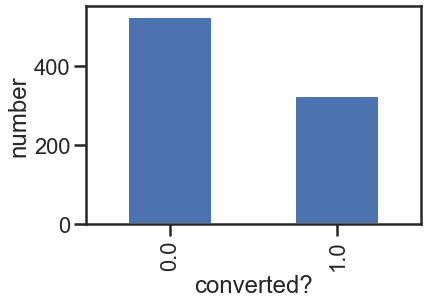

In [58]:
value=df_X_all_imp_filtered["converted"].value_counts().plot(kind='bar')
plt.xlabel('converted?')
plt.ylabel('number')
#--> The data is balanced 

### 4.2) Data splitting and scaling
<p> We split the data-frame into two parts. One is training set, consists of 70% of the data, on which the model(s) will be trained and the other one is test set, consists of remaining 30% of the data, on which the model(s) will be validated. </p>

In [59]:
X_data_new = df_X_all_imp_filtered.iloc[:, 2:]
y_data_new = df_X_all_imp_filtered["converted"]

In [60]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_split_test(X_data_new, y_data_new, X_data_new.columns)

#feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_ss = sc_X.fit_transform(X_train)
X_test_ss = sc_X.transform(X_test)

X_train (595, 8)
y_train (595,)
X_test (255, 8)
y_test (255,)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


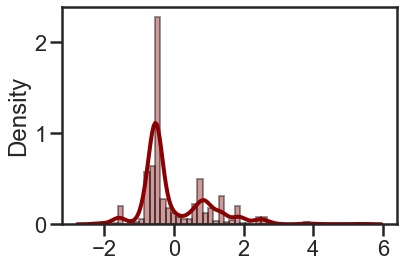

In [82]:
#check the distribution of the scaled data. It follows a normal distribution
bp=sns.distplot(np.asarray(X_train_ss, float),  kde=True, bins=50,
             color = 'darkred',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### 4.3) Model Construction
<p> To buid machine learninng models, I rely on the following algorithms: (i) a baseline one which is Logistic Regression, a probabilistic one which is Naive BAyes, and a tree-based one which is Random Forest.</p>

<p>
For each of the three models I will perform the task according to the following template:</br>
    - Training the model on the training set(tuning the hyper-parameters if needed)</br>
    - Making prediction on both train and test set</br>
    - Calculate the evaluation matrics for both the sets and provide the classification reports</br>
    - Plotting ROC curve and confusion matrix for both the sets 
</p>

#### -->  <b>  Using Logistic Regression  </b> 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


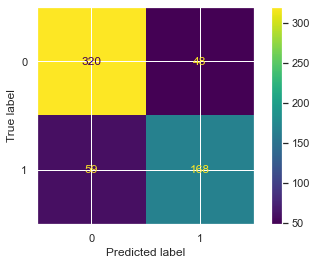


 ***Evaluation of the "training" dataset***

accuracy................. 0.8202
precision................ 0.7778
recall................... 0.7401
F1....................... 0.7585
auc...................... 0.8048
mcc...................... 0.6158


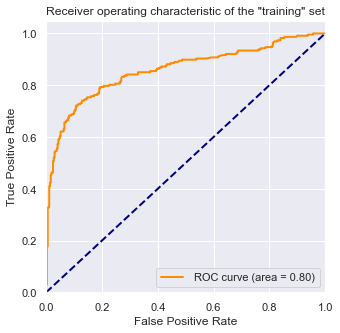


Classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       368
           1       0.78      0.74      0.76       227

    accuracy                           0.82       595
   macro avg       0.81      0.80      0.81       595
weighted avg       0.82      0.82      0.82       595



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


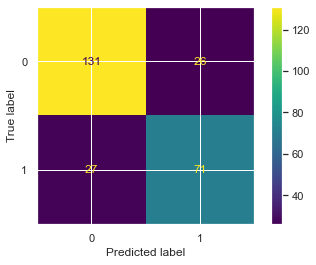


 ***Evaluation of the "test" dataset***

accuracy................. 0.7922
precision................ 0.7320
recall................... 0.7245
F1....................... 0.7282
auc...................... 0.7794
mcc...................... 0.5600


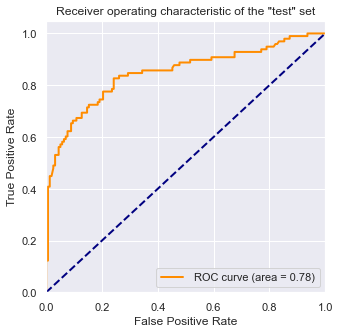


Classification report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       157
           1       0.73      0.72      0.73        98

    accuracy                           0.79       255
   macro avg       0.78      0.78      0.78       255
weighted avg       0.79      0.79      0.79       255



In [135]:
lr = LogisticRegression()
lr.fit(X_train_ss, y_train)
evaluate_your_model_metrics(lr, X_train_ss, y_train, '"training"')
evaluate_your_model_metrics(lr, X_test_ss, y_test, '"test"')

Feature: 0, Score: -0.86922
Feature: 1, Score: 1.27231
Feature: 2, Score: -0.44817
Feature: 3, Score: -0.29862
Feature: 4, Score: -0.13227
Feature: 5, Score: 0.02845
Feature: 6, Score: 0.23845
Feature: 7, Score: 0.14157


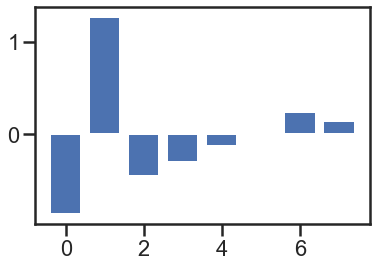

Dimension of the final set of candidate predictors from LR:  (8,)


In [99]:
# get importance for the logistic regrssion model
importance = lr.coef_[0] #for lr
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print("Dimension of the final set of candidate predictors from LR: ", importance.shape)

In [100]:
#Get the predictors labels
feature_predictors_df = pd.DataFrame(importance, columns = ["feature_importance"])
feature_predictors_df["feature_label"] = X_data_new.columns
#--Sort the feature weights within descending order
feature_predictors_df_abs = feature_predictors_df
feature_predictors_df_abs["feature_importance"] = feature_predictors_df["feature_importance"].abs()
sorted_feature_predictors_df = feature_predictors_df_abs.sort_values(["feature_importance"], ascending = False)
sorted_feature_predictors_df.head(10)

,feature_importance,feature_label
1,1.272313,gender
0,0.869218,customer_segment
2,0.448167,age
3,0.298624,related_customers
6,0.238446,credit_account_id
7,0.141566,branch
4,0.132265,family_size
5,0.028447,initial_fee_level


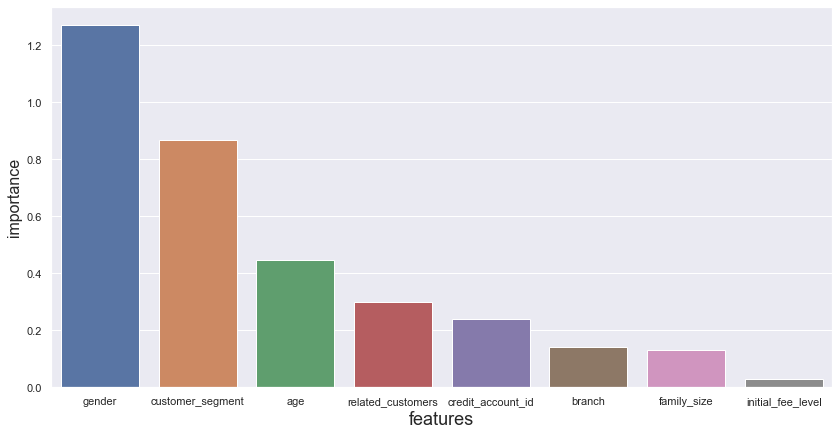

In [102]:
plt.figure(figsize=(14,7))
sns.set(font_scale = 1)
plots = sns.barplot(x="feature_label", y="feature_importance", data=sorted_feature_predictors_df)
plt.xlabel('features', fontsize=18)
plt.ylabel('importance', fontsize=16)
plt.show()

#### --> <b> Using Naive Bayes </b>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


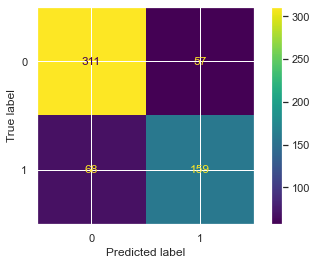


 ***Evaluation of the "training" dataset***

accuracy................. 0.7899
precision................ 0.7361
recall................... 0.7004
F1....................... 0.7178
auc...................... 0.7728
mcc...................... 0.5511


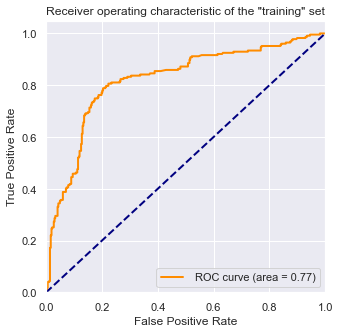


Classification report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       368
           1       0.74      0.70      0.72       227

    accuracy                           0.79       595
   macro avg       0.78      0.77      0.78       595
weighted avg       0.79      0.79      0.79       595



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


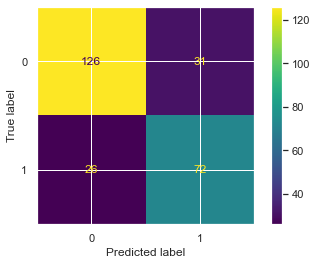


 ***Evaluation of the "test" dataset***

accuracy................. 0.7765
precision................ 0.6990
recall................... 0.7347
F1....................... 0.7164
auc...................... 0.7686
mcc...................... 0.5326


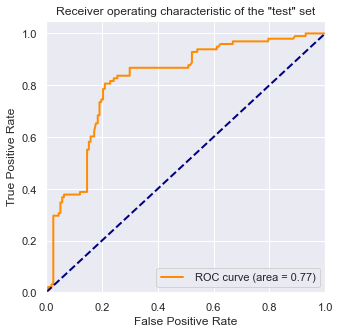


Classification report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       157
           1       0.70      0.73      0.72        98

    accuracy                           0.78       255
   macro avg       0.76      0.77      0.77       255
weighted avg       0.78      0.78      0.78       255



In [136]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_ss, y_train)
preds = gnb.predict(X_test_ss)
evaluate_your_model_metrics(gnb, X_train_ss, y_train, '"training"')
evaluate_your_model_metrics(gnb, X_test_ss, y_test, '"test"')

In [116]:
imps = permutation_importance(gnb, X_test_ss, y_test)
gnb_importances = imps.importances_mean

importances = pd.DataFrame({
    'Feature': X_data_new.columns,
    'Importance': gnb_importances
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
gender,0.110588
credit_account_id,0.018039
initial_fee_level,0.009412
customer_segment,0.008627
family_size,0.008627
related_customers,0.004706
age,-0.000784
branch,-0.003922


#### -->  <b> Using Random Forest  <b> 

In [126]:
param_grid = {"n_estimators": range(20, 100, 2),
              "max_depth": range(4, 50, 2),
              "min_samples_leaf": range(2, 100, 2),
              "max_features": ['auto', 'sqrt'],#sp_randint(1, n_features),
              "min_samples_split": [2, 5, 10], # sp_randint(2, 10),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

clf = RandomForestClassifier(class_weight = 'balanced')
n_iter_search = 100
estimator = RandomizedSearchCV(clf,
                               param_distributions = param_grid,
                               n_iter = n_iter_search,
                               scoring = 'roc_auc',
                               verbose = 2,
                               n_jobs = 10)
      
fit = estimator.fit(X_train_ss, y_train)
best_model = estimator.best_estimator_
print('\nbest_model:\n', best_model)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

best_model:
 RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=28,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=74)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


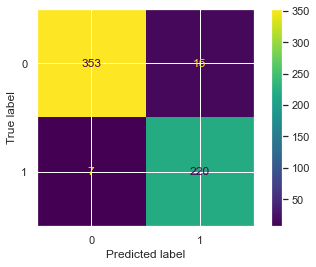


 ***Evaluation of the "training" dataset***

accuracy................. 0.9630
precision................ 0.9362
recall................... 0.9692
F1....................... 0.9524
auc...................... 0.9642
mcc...................... 0.9225


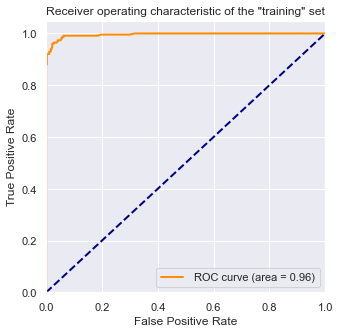


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       368
           1       0.94      0.97      0.95       227

    accuracy                           0.96       595
   macro avg       0.96      0.96      0.96       595
weighted avg       0.96      0.96      0.96       595



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


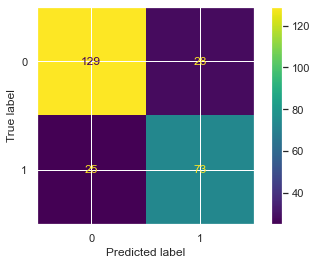


 ***Evaluation of the "test" dataset***

accuracy................. 0.7922
precision................ 0.7228
recall................... 0.7449
F1....................... 0.7337
auc...................... 0.7833
mcc...................... 0.5635


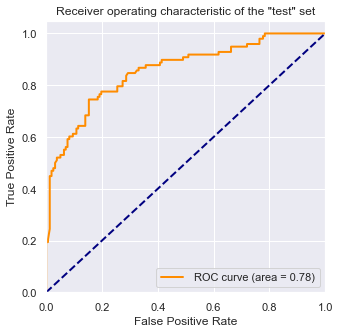


Classification report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       157
           1       0.72      0.74      0.73        98

    accuracy                           0.79       255
   macro avg       0.78      0.78      0.78       255
weighted avg       0.79      0.79      0.79       255



In [137]:
evaluate_your_model_metrics(best_model, X_train_ss, y_train, '"training"')
evaluate_your_model_metrics(best_model, X_test_ss, y_test, '"test"')

<p> <b> <h3> Main conclusions</h1> </b> 
==> Unfortunately, RF shows a clear overfitting when we compare the performance of the trainning set vs the test set. </br>
LR showed the best performance with an AUC=0.80/0.78 and accuracy=0.82/0.79 for training/test sets. It also outperformed Naive Bayes.</br>
I then consider the results of LR to identify predictors of whether a customer would convert or not. </br> 
<h4> <b>The results show that 'gender' is the most predictive factor, followed  by 'customer_segment'.</b></h3>

</p>